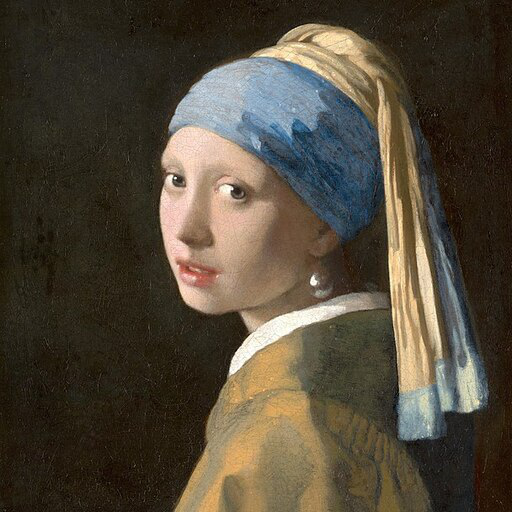

In [13]:
from diffusers.utils import load_image

image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

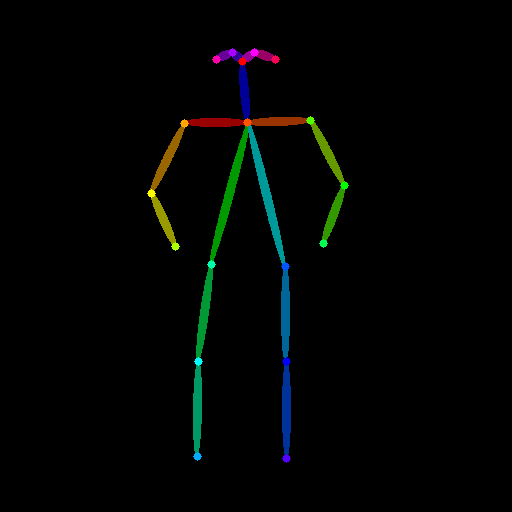

In [21]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

openpose_image = openpose(image)

openpose_image

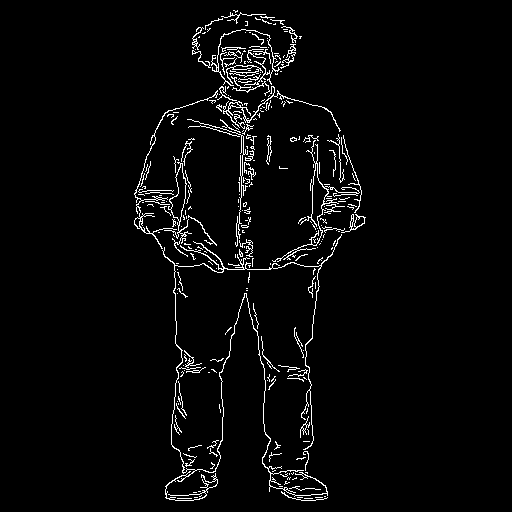

In [23]:
import cv2
from PIL import Image
import numpy as np

def get_canny(image):
    img = np.array(image)

    low_threshold = 100
    high_threshold = 200

    img = cv2.Canny(img, low_threshold, high_threshold)
    img = img[:, :, None]
    img = np.concatenate([img, img, img], axis=2)
    return Image.fromarray(img)

canny_image = get_canny(image)

canny_image

In [17]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from pathlib import Path

model_id = "runwayml/stable-diffusion-v1-5"  # TODO: enable cetus-mix

controlnet = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16),
]

pipe = StableDiffusionControlNetPipeline.from_pretrained(model_id, controlnet=controlnet, torch_dtype=torch.float16, safety_checker=None)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

pipe

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.17.1",
  "controlnet": [
    "controlnet",
    "MultiControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [24]:
prompt = "mr potato head, best quality, extremely detailed"
prompt = [t + prompt for t in ["Sandra Oh", "Kim Kardashian", "rihanna", ""]]
generator = [torch.Generator(device="cuda").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    image=[canny_image,openpose_image],
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=30,
    generator=generator,
)

output

You have 2 ControlNets and you have passed 4 prompts. The conditionings will be fixed across the prompts.
100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F3BF7BFE650>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F3BF7BFC340>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F3BF7BFD720>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F3BF7BFE620>], nsfw_content_detected=None)

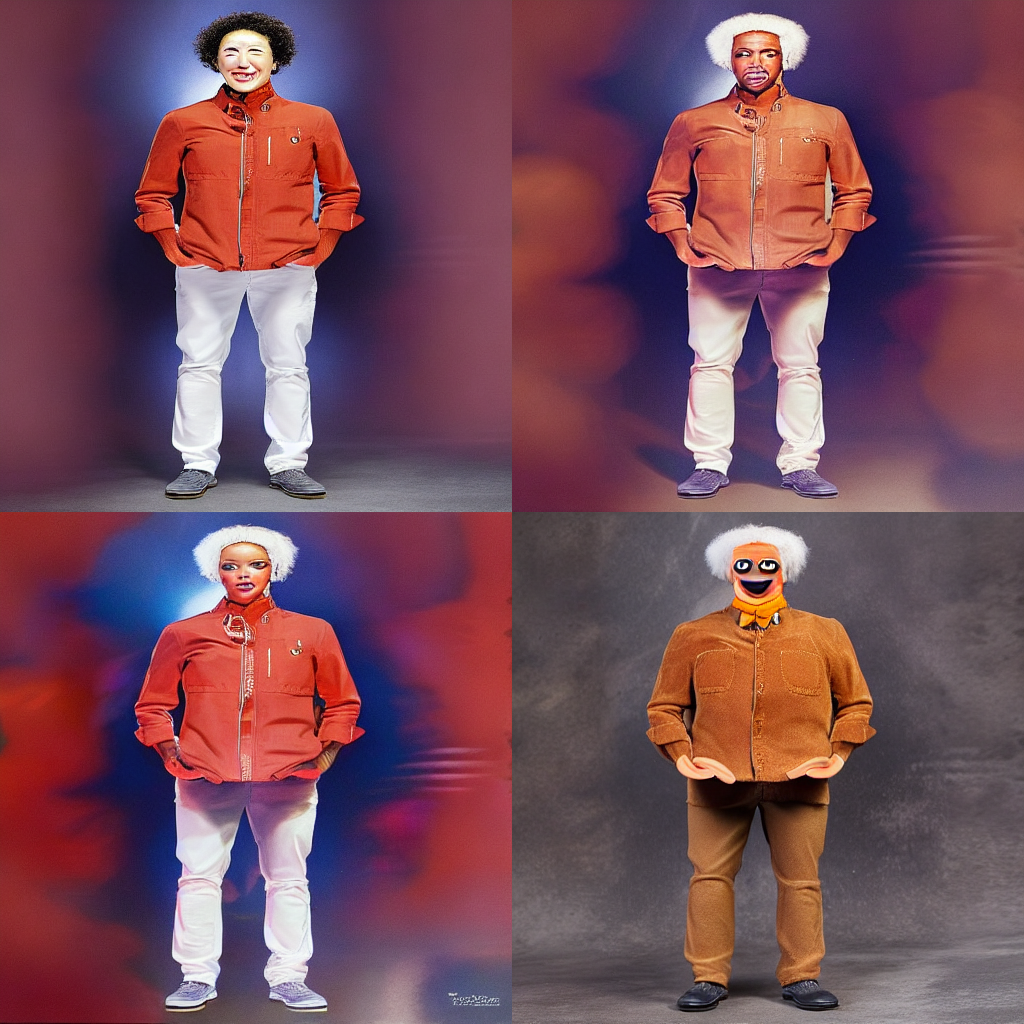

In [25]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

image_grid(output.images, 2, 2)